In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime as dt

from tools import make_track, make_ER, kalman_filter, ols_regression, lasso_regression, ridge_regression, ml_kalman_filter
from hc_graph import hc_stock
sns.set()

In [3]:
prices_index = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True,
                     dayfirst=True)[['BNPIFEU',"SPGSGCP","BPFXCAD1"]]
prices_risk_premia = pd.read_csv(r"financial_data/bnp_risk_premia_data.csv", index_col=0, parse_dates=True, 
                                 dayfirst=True)[["BNPIMDEA"]]


prices = pd.concat([prices_index, prices_risk_premia],axis=1).dropna()
returns = prices.pct_change().dropna()

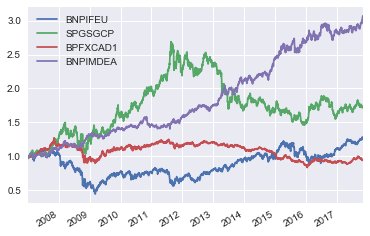

In [4]:
(prices/prices.iloc[0]).plot()

In [5]:
returns.corr(method="pearson")

,BNPIFEU,SPGSGCP,BPFXCAD1,BNPIMDEA
BNPIFEU,1.000000,0.000458,0.478554,0.028712
SPGSGCP,0.000458,1.000000,0.289302,0.121350
BPFXCAD1,0.478554,0.289302,1.000000,-0.023820
BNPIMDEA,0.028712,0.121350,-0.023820,1.000000


In [6]:
#n_reweight = 300
#reweight_cal = returns.iloc[40:].sample(n_reweight).sort_index().index
#df_reweight = pd.DataFrame(index=reweight_cal, data= np.random.normal(0.3,0.2,
#                          size=(n_reweight,len(prices.columns))), columns=prices.columns)
#df_reweight.to_pickle("df_reweight.pkl")

In [7]:
df_reweight = pd.read_pickle("df_reweight.pkl")

In [8]:
df_reweight.head()

,BNPIFEU,SPGSGCP,BPFXCAD1,BNPIMDEA
2007-03-30,-0.144028,0.023759,0.260516,-0.050083
2007-04-18,0.293833,0.366327,-0.171533,0.639337
2007-04-27,0.107123,0.242490,0.211881,0.147367
2007-05-11,0.318633,0.353642,0.741058,-0.019458
2007-05-18,0.269846,0.614240,0.512564,0.726749


In [9]:
# Vol weighted index

#vol = universe.rolling(window=40).std().dropna()*np.sqrt(252)
weight = df_reweight

prices_for_track = prices.loc[weight.index[0]:]
vol_cap = make_track(prices_for_track,weight,0)

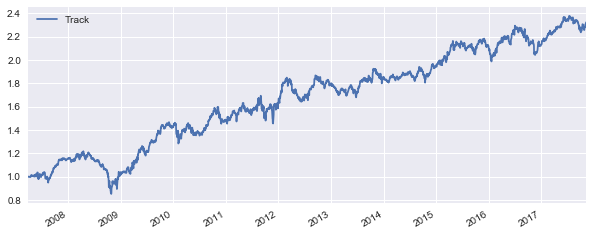

In [10]:
vol_cap.plot(figsize=(10,4))

In [11]:
## Replication Data

vol_cap_returns = vol_cap.pct_change().dropna()
universe_returns = returns.loc[vol_cap_returns.index]

size = 52
freq = 1

In [86]:
%%time
df_weight_ols = ols_regression(vol_cap_returns, universe_returns, size, freq)
prices_for_track = prices.loc[df_weight_ols.index[0]:]
replication = make_track(prices_for_track, df_weight_ols)

df_res = vol_cap.loc[replication.index[0]:].copy()
df_res["OLS"] = replication.loc[df_res.index]

CPU times: user 13.3 s, sys: 108 ms, total: 13.4 s
Wall time: 14 s


In [87]:
#df_weight_ridge = ridge_regression(vol_cap_returns, universe_returns, size, freq,l=5e-5)
#prices_for_track = prices.loc[df_weight_ridge.index[0]:]
#replication_ridge = make_track(prices_for_track, df_weight_ridge)
#
#df_res["Ridge"] = replication_ridge.loc[df_res.index]
#df_res = df_res/df_res.iloc[0]

In [88]:
#%%time
#df_weight_lasso = lasso_regression(vol_cap_returns, universe_returns, size, freq,l=5e-6)
#prices_for_track = prices.loc[df_weight_lasso.index[0]:]
#replication_lasso = make_track(prices_for_track, df_weight_lasso)
#
#df_res["Lasso"] = replication_lasso.loc[df_res.index]
#df_res = df_res/df_res.iloc[0]

In [89]:
%%time

for nu in [125,150,175]:
    
    df_weight_kalman_ = kalman_filter(vol_cap_returns, universe_returns, freq, sigma_weight=nu*0.1 , sigma_return=0.1)
    df_weight_kalman = df_weight_kalman_.loc[df_weight_ols.index[0]:]

    prices_for_track_kalman = prices.loc[df_weight_ols.index[0]:]
    replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_res.index[0]:]
    df_res["Kalman {}".format(nu)] = replication_kalman

CPU times: user 39.4 s, sys: 302 ms, total: 39.7 s
Wall time: 41.2 s


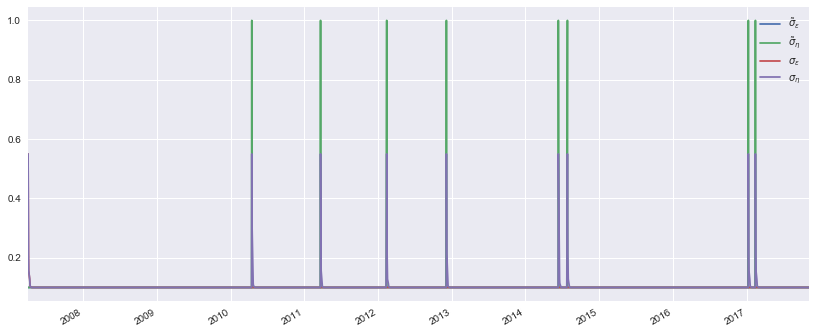

CPU times: user 22.5 s, sys: 150 ms, total: 22.6 s
Wall time: 23 s


In [90]:
%%time
tau = 0.5

for tau in [0.25]:
    df_weight_ml_kalman_ = ml_kalman_filter(vol_cap_returns, universe_returns, freq, tau=0.5, plot_sigma=True)
    df_weight_ml_kalman = df_weight_ml_kalman_.loc[df_weight_ols.index[0]:]
    prices_for_track_kalman_ml = prices.loc[df_weight_ols.index[0]:]
    replication_kalman_ml = make_track(prices_for_track_kalman_ml, df_weight_ml_kalman).loc[df_res.index[0]:]
    df_res["Kalman_ML {}".format(tau)] = replication_kalman_ml

In [91]:
#df_weight_kalman_.iloc[:20].plot(figsize=(10,6))

In [92]:
df_res = df_res / df_res.iloc[0]

In [93]:
df_res.head()

,Track,OLS,Kalman 125,Kalman 150,Kalman 175,Kalman_ML 0.25
2007-06-18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2007-06-19,1.005637,1.005368,1.005806,1.005803,1.005801,1.001392
2007-06-20,1.001932,1.001162,1.002010,1.002010,1.002011,1.000420
2007-06-21,0.992086,0.997008,0.992139,0.992142,0.992144,0.997493
2007-06-22,0.988562,0.994050,0.990357,0.990360,0.990361,0.997158


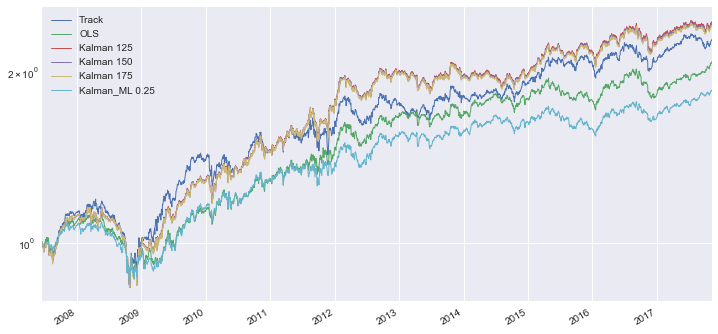

In [94]:
df_res.plot(figsize=(12,6),linewidth=1, logy=True)

In [95]:
g = hc_stock(df_res)
g.plot()

In [96]:
df_res.pct_change().corr(method="pearson")

,Track,OLS,Kalman 125,Kalman 150,Kalman 175,Kalman_ML 0.25
Track,1.000000,0.834982,0.908797,0.908901,0.908953,0.846186
OLS,0.834982,1.000000,0.869553,0.868005,0.866954,0.969680
Kalman 125,0.908797,0.869553,1.000000,0.999926,0.999776,0.869666
Kalman 150,0.908901,0.868005,0.999926,1.000000,0.999959,0.868297
Kalman 175,0.908953,0.866954,0.999776,0.999959,1.000000,0.867380
Kalman_ML 0.25,0.846186,0.969680,0.869666,0.868297,0.867380,1.000000


In [97]:
df_res.pct_change().corr(method="kendall")

,Track,OLS,Kalman 125,Kalman 150,Kalman 175,Kalman_ML 0.25
Track,1.000000,0.672502,0.785370,0.786157,0.786713,0.687073
OLS,0.672502,1.000000,0.704679,0.702146,0.700365,0.855236
Kalman 125,0.785370,0.704679,1.000000,0.992840,0.987612,0.708931
Kalman 150,0.786157,0.702146,0.992840,1.000000,0.994756,0.706638
Kalman 175,0.786713,0.700365,0.987612,0.994756,1.000000,0.704963
Kalman_ML 0.25,0.687073,0.855236,0.708931,0.706638,0.704963,1.000000


In [98]:
returns_track = df_res.pct_change().dropna()
track = returns_track['Track']
returns_track = returns_track.drop('Track', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - track.values).std(axis=1)
df['$R^2$'] = 1 - (returns_track.T - track.values).var(axis=1) / track.values.var()
df

,Tracking error,$R^2$
OLS,0.004556,0.691271
Kalman 125,0.003501,0.817689
Kalman 150,0.003500,0.817744
Kalman 175,0.003500,0.817743
Kalman_ML 0.25,0.004371,0.715860


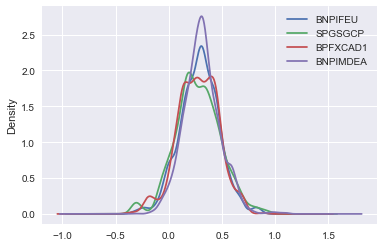

In [24]:
df_weight_kalman.plot(kind="kde")

In [25]:
df_weight_kalman.mean()

BNPIFEU     0.286303
SPGSGCP     0.273610
BPFXCAD1    0.274071
BNPIMDEA    0.310184
dtype: float64

In [26]:
df_weight_kalman.std()

BNPIFEU     0.185250
SPGSGCP     0.211525
BPFXCAD1    0.190324
BNPIMDEA    0.168603
dtype: float64

In [27]:
df_weight_kalman.describe()

,BNPIFEU,SPGSGCP,BPFXCAD1,BNPIMDEA
count,2576.000000,2576.000000,2576.000000,2576.000000
mean,0.286303,0.273610,0.274071,0.310184
std,0.185250,0.211525,0.190324,0.168603
min,-0.353886,-0.330940,-0.399714,-0.316473
25%,0.170798,0.144643,0.143539,0.204006
50%,0.293116,0.268235,0.277615,0.306102
75%,0.407952,0.410379,0.411277,0.405881
max,0.852515,0.944297,0.896281,1.103142


In [28]:
df_weight_kalman["BNPIFEU"]

2007-06-18    0.500642
2007-06-19    0.504760
2007-06-20    0.505047
2007-06-21    0.502687
2007-06-22    0.569149
2007-06-25    0.572787
2007-06-26    0.334496
2007-06-27    0.313008
2007-06-28    0.308987
2007-06-29    0.283916
2007-07-02    0.284015
2007-07-03    0.308297
2007-07-05    0.359735
2007-07-06    0.311040
2007-07-09    0.254243
2007-07-10    0.241821
2007-07-11    0.270808
2007-07-12    0.289586
2007-07-13    0.264402
2007-07-16    0.283097
2007-07-17    0.308281
2007-07-18    0.285938
2007-07-19    0.297390
2007-07-20    0.317041
2007-07-23    0.313746
2007-07-24    0.316649
2007-07-25    0.326262
2007-07-26    0.321142
2007-07-27    0.337324
2007-07-30    0.336212
                ...   
2017-09-28    0.162361
2017-09-29    0.243685
2017-10-02    0.243329
2017-10-03    0.241949
2017-10-04    0.254860
2017-10-05    0.256513
2017-10-06    0.264717
2017-10-09    0.285791
2017-10-10    0.284820
2017-10-11    0.284212
2017-10-12    0.285964
2017-10-13    0.286275
2017-10-16 